In [54]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow import keras
# from numba import cuda

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_curve

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")

Loading Libraries Done


In [55]:
main_folder = "Autism dataset\consolidated"
RANDOM_SEED = 6

categories = os.listdir(main_folder)
try:
    categories.remove(".DS_Store")
except:
    pass
print(categories, len(categories))


['Autistic', 'Non_Autistic'] 2


In [56]:
TOTAL_CATEGORIES = len(categories)
IMAGE_SIZE = (224,224,3)

def load_images_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        print(index, category)
        for image_name in tqdm(os.listdir(main_folder+"/"+category)):
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg") or (file_ext.lower() == "png") or (file_ext.lower() == "bmp"):
              try:
                    imgname = main_folder+"/"+category+"/"+image_name
                    imgname = imgname.replace("//", "/")
                    img = cv2.imread(imgname)
                    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    img_rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    img_rotated_180 = cv2.rotate(img, cv2.ROTATE_180)
                    img_rotated_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    img_flip_ver = cv2.flip(img, 0)
                    img_flip_hor = cv2.flip(img, 1)

                    img_array = Image.fromarray(img, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_90, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_90, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_180, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_270, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_ver, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_hor, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

              except:
                    print(imgname)
                    print(img)
                

    return img_lst, labels

images, labels = load_images_labels(categories)
print()
print("Total Images Loaded:", len(images))

0 Autistic


100%|██████████| 1470/1470 [00:14<00:00, 101.99it/s]


1 Non_Autistic


100%|██████████| 1470/1470 [00:24<00:00, 59.77it/s]


Total Images Loaded: 20580


In [57]:
images = np.array(images)
labels = np.array(labels)

In [58]:
images = images.astype(np.float32)
labels = labels.astype(np.int8)
images /= 255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (20580, 224, 224, 3)


In [59]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = RANDOM_SEED)

x_train = x_train[:1500]
y_train = y_train[:1500]

x_val = x_test[:500]
y_val = y_test[:500]

x_test = x_test[500:1000]
y_test = y_test[500:1000]

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("x_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)
print("x_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1500, 224, 224, 3)
y_train shape =  (1500,)
x_val shape =  (500, 224, 224, 3)
y_val shape =  (500,)
x_test shape =  (500, 224, 224, 3)
y_test shape =  (500,)


In [60]:
del labels
del images

# VGG19 model

In [61]:
EPOCHS = 60
BATCH_SIZE = 16

In [62]:
vgg = VGG19(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [63]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [64]:
x = Flatten()(vgg.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
vgg_model = Model(inputs=vgg.input, outputs=prediction)
vgg_model.summary()# view the structure of the model

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [65]:
vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer="SGD", metrics=['accuracy'])

In [66]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=5, restore_best_weights=True)

In [67]:
# fit the model
vgg_history = vgg_model.fit(x_train, y_train, validation_data=(x_val,y_val), steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_val.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/60
10/10 [==============================] - 5s 336ms/step - loss: 1.0323 - accuracy: 0.5562 - val_loss: 6.9357 - val_accuracy: 0.4839
Epoch 2/60
10/10 [==============================] - 3s 273ms/step - loss: 0.9571 - accuracy: 0.5813 - val_loss: 8.8730 - val_accuracy: 0.4839
Epoch 3/60
10/10 [==============================] - 3s 278ms/step - loss: 0.8597 - accuracy: 0.6187 - val_loss: 6.5513 - val_accuracy: 0.4839
Epoch 4/60
10/10 [==============================] - 3s 277ms/step - loss: 0.9067 - accuracy: 0.5562 - val_loss: 3.0424 - val_accuracy: 0.4839
Epoch 5/60
10/10 [==============================] - 3s 277ms/step - loss: 0.7807 - accuracy: 0.6000 - val_loss: 2.7911 - val_accuracy: 0.4839
Epoch 6/60
10/10 [==============================] - 3s 281ms/step - loss: 0.6998 - accuracy: 0.6687 - val_loss: 2.4225 - val_accuracy: 0.4839
Epoch 7/60
10/10 [==============================] - 3s 281ms/step - loss: 0.7760 - accuracy: 0.6687 - val_loss: 2.1584 - val_accuracy: 0.4839
Epoch 

In [68]:
tf.keras.backend.clear_session()
vgg_loss, vgg_acc = vgg_model.evaluate(x_test,y_test,batch_size=32)
print("VGG 19 Loss:", vgg_loss)
print("VGG 19 Accuracy:", vgg_acc*100, "%")

16/16 [==============================] - 2s 109ms/step - loss: 0.5475 - accuracy: 0.7100
VGG 19 Loss: 0.5475047826766968
VGG 19 Accuracy: 70.99999785423279 %


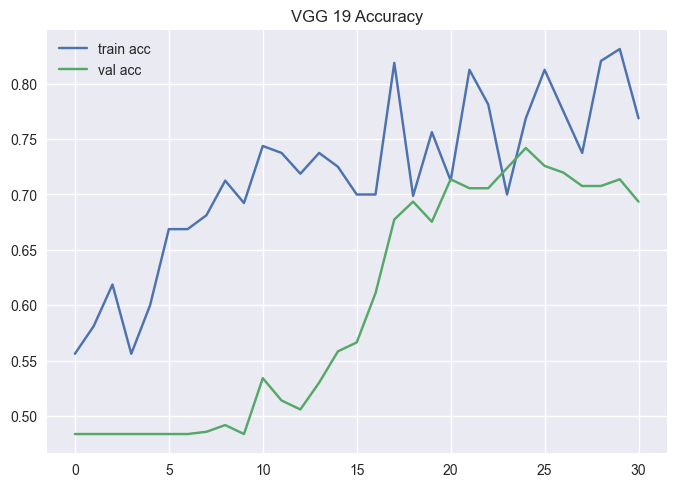

In [69]:
# accuracies
plt.plot(vgg_history.history['accuracy'], label='train acc')
plt.plot(vgg_history.history['val_accuracy'], label='val acc')
plt.title("VGG 19 Accuracy")
plt.legend()
plt.show()

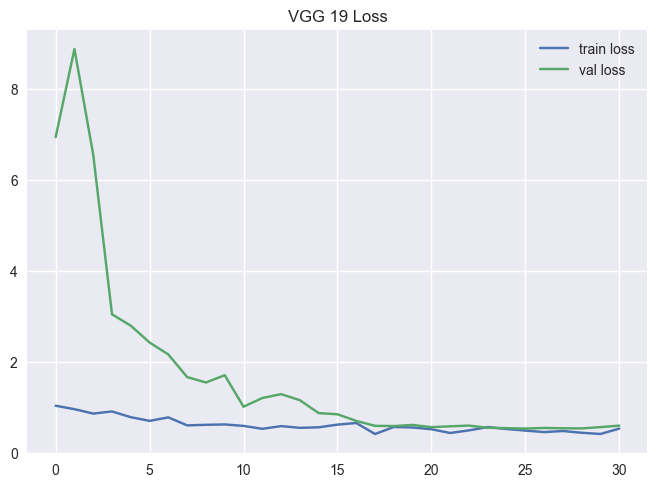

In [70]:
# loss
plt.plot(vgg_history.history['loss'], label='train loss')
plt.plot(vgg_history.history['val_loss'], label='val loss')
plt.title("VGG 19 Loss")
plt.legend()
plt.show()

In [71]:
#predict
y_pred = vgg_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,y_test))#get classification report

16/16 [==============================] - 2s 108ms/step
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       253
           1       0.70      0.71      0.71       247

    accuracy                           0.71       500
   macro avg       0.71      0.71      0.71       500
weighted avg       0.71      0.71      0.71       500



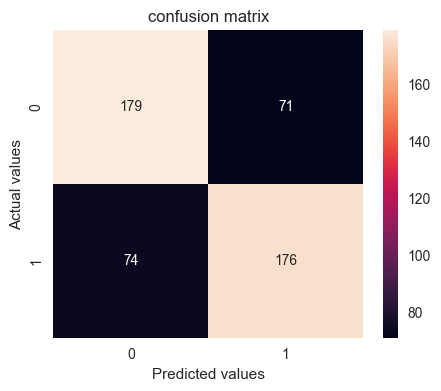

In [72]:
plt.figure(figsize=(5,4))
plt.title("confusion matrix")
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

[[179  74]
 [ 71 176]]
16/16 [==============================] - 2s 108ms/step


C:\Users\91997\AppData\Local\Temp\ipykernel_19360\1455436863.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


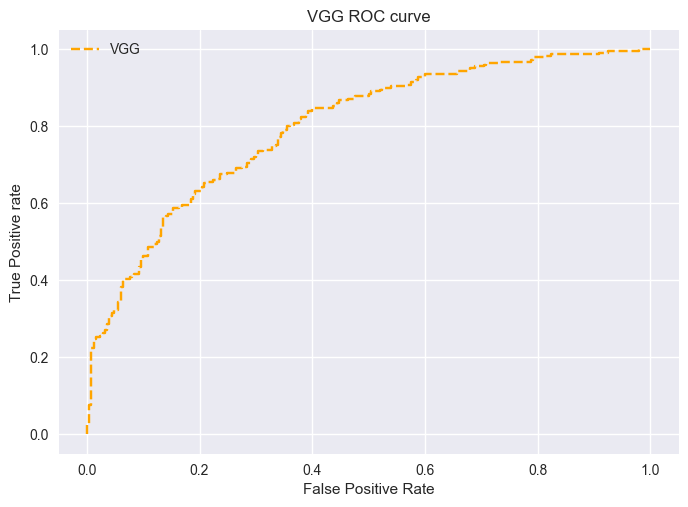

In [73]:
print(confusion_matrix(y_pred,y_test))
pred_prob1 =vgg_model.predict(x_test)
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)

plt.style.use('seaborn')

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label=r'VGG')
plt.title('VGG ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [74]:
vgg_model.save("Model\AutismDetection_vgg_model.h5", save_format="h5")

del vgg_history
del y_pred

gc.collect()

17161

# RESNET50 model

In [75]:
resnet_50 = ResNet50(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [76]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_50.layers:
    layer.trainable = False

In [77]:
x = Flatten()(resnet_50.output)

#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_model = Model(inputs=resnet_50.input, outputs=prediction)
resnet_50_model.summary()# view the structure of the model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [78]:
resnet_50_model.compile(loss='sparse_categorical_crossentropy', optimizer="SGD", metrics=['accuracy'])

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

# fit the model
resnet_50_history = resnet_50_model.fit(x_train, y_train, validation_data=(x_val,y_val), steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_val.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/60
10/10 [==============================] - 5s 269ms/step - loss: 223.3305 - accuracy: 0.3938 - val_loss: 68.7471 - val_accuracy: 0.5161
Epoch 2/60
10/10 [==============================] - 1s 153ms/step - loss: 192.8910 - accuracy: 0.4688 - val_loss: 47.0270 - val_accuracy: 0.4839
Epoch 3/60
10/10 [==============================] - 1s 154ms/step - loss: 183.2548 - accuracy: 0.4938 - val_loss: 243.2791 - val_accuracy: 0.4839
Epoch 4/60
10/10 [==============================] - 1s 153ms/step - loss: 208.9323 - accuracy: 0.4625 - val_loss: 311.4410 - val_accuracy: 0.4839
Epoch 5/60
10/10 [==============================] - 1s 152ms/step - loss: 181.7879 - accuracy: 0.4938 - val_loss: 249.0258 - val_accuracy: 0.5161
Epoch 6/60
10/10 [==============================] - 1s 152ms/step - loss: 186.6603 - accuracy: 0.5063 - val_loss: 122.2951 - val_accuracy: 0.4839
Epoch 7/60
10/10 [==============================] - 1s 152ms/step - loss: 167.3552 - accuracy: 0.5063 - val_loss: 251.2005 - v

In [79]:
resnet_50_loss,resnet_50_acc = resnet_50_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50 Loss:", resnet_50_loss)
print("Resnet_50 Accuracy:", resnet_50_acc*100, "%")

16/16 [==============================] - 1s 56ms/step - loss: 24.2384 - accuracy: 0.5220
Resnet_50 Loss: 24.2383975982666
Resnet_50 Accuracy: 52.20000147819519 %


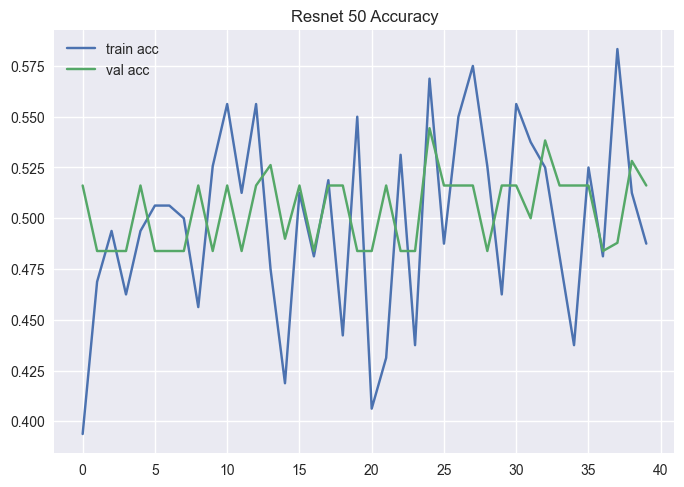

In [80]:
# accuracies
plt.plot(resnet_50_history.history['accuracy'], label='train acc')
plt.plot(resnet_50_history.history['val_accuracy'], label='val acc')
plt.title("Resnet 50 Accuracy")
plt.legend()
plt.show()

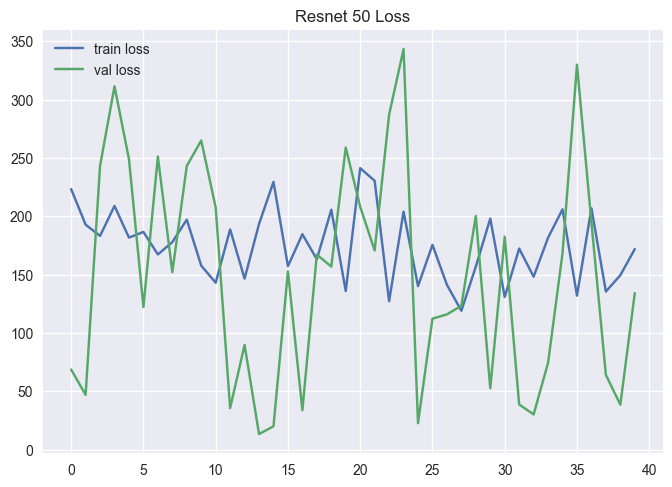

In [81]:
# loss
plt.plot(resnet_50_history.history['loss'], label='train loss')
plt.plot(resnet_50_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 Loss")
plt.legend()
plt.show()

In [82]:
#predict
y_pred=resnet_50_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

16/16 [==============================] - 2s 55ms/step
              precision    recall  f1-score   support

           0       1.00      0.51      0.68       489
           1       0.04      1.00      0.08        11

    accuracy                           0.52       500
   macro avg       0.52      0.76      0.38       500
weighted avg       0.98      0.52      0.66       500



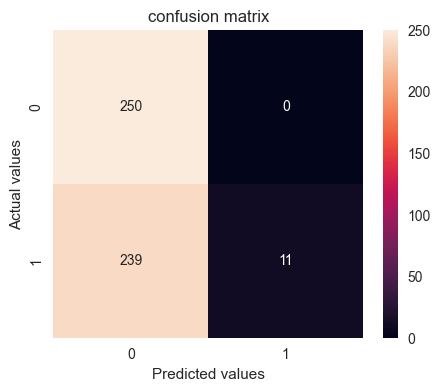

In [83]:
plt.figure(figsize=(5,4))
plt.title("confusion matrix")
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

[[250 239]
 [  0  11]]
16/16 [==============================] - 2s 109ms/step


C:\Users\91997\AppData\Local\Temp\ipykernel_19360\661079358.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


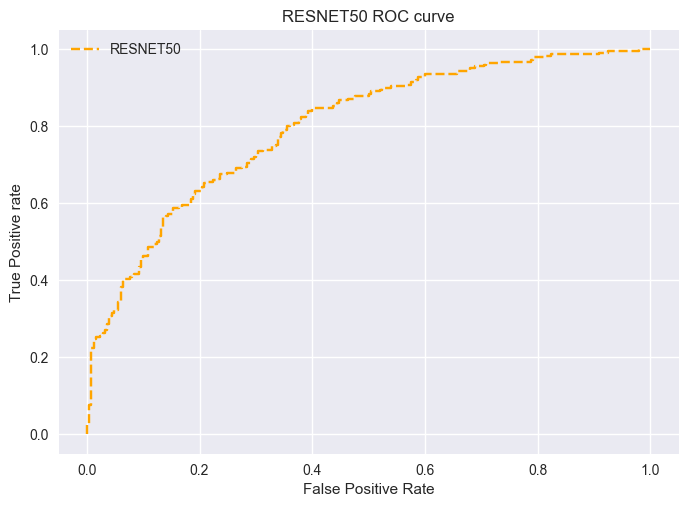

In [84]:
print(confusion_matrix(y_pred,y_test))
pred_prob2 =vgg_model.predict(x_test)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

plt.style.use('seaborn')

plt.plot(fpr2, tpr2, linestyle='--',color='orange', label=r'RESNET50')
plt.title('RESNET50 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [85]:
resnet_50_model.save("Model\AutismDetection_resnet_50_model.h5", save_format="h5")

del resnet_50_history
del y_pred

gc.collect()

27520

# RESNET50 V2

In [86]:
resnet_50_v2 = ResNet50V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [87]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_50_v2.layers:
    layer.trainable = False

In [88]:
x = Flatten()(resnet_50_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_v2_model = Model(inputs=resnet_50_v2.input, outputs=prediction)
# view the structure of the model
resnet_50_v2_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [89]:
resnet_50_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="SGD", metrics=['acc'])

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

# fit the model
resnet_50_v2_history = resnet_50_v2_model.fit(x_train, y_train, validation_data=(x_val,y_val), steps_per_epoch = 10, epochs=150, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_val.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/150
10/10 [==============================] - 5s 239ms/step - loss: 0.8500 - acc: 0.5625 - val_loss: 1.6168 - val_acc: 0.5242
Epoch 2/150
10/10 [==============================] - 1s 151ms/step - loss: 0.8965 - acc: 0.5312 - val_loss: 1.2938 - val_acc: 0.5101
Epoch 3/150
10/10 [==============================] - 1s 151ms/step - loss: 0.8058 - acc: 0.6313 - val_loss: 0.8047 - val_acc: 0.6230
Epoch 4/150
10/10 [==============================] - 1s 150ms/step - loss: 0.8400 - acc: 0.6000 - val_loss: 0.6502 - val_acc: 0.6633
Epoch 5/150
10/10 [==============================] - 1s 150ms/step - loss: 0.9128 - acc: 0.5625 - val_loss: 0.8107 - val_acc: 0.6371
Epoch 6/150
10/10 [==============================] - 1s 151ms/step - loss: 0.7244 - acc: 0.6438 - val_loss: 0.6850 - val_acc: 0.6310
Epoch 7/150
10/10 [==============================] - 1s 150ms/step - loss: 0.8585 - acc: 0.6000 - val_loss: 0.6228 - val_acc: 0.6895
Epoch 8/150
10/10 [==============================] - 1s 152ms/step - 

In [90]:
resnet_50_v2_loss,resnet_50_v2_acc = resnet_50_v2_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50_V2 Loss:", resnet_50_v2_loss)
print("Resnet_50_V2 Accuracy:", resnet_50_v2_acc*100, "%")

16/16 [==============================] - 1s 54ms/step - loss: 1.1229 - acc: 0.7140
Resnet_50_V2 Loss: 1.122921347618103
Resnet_50_V2 Accuracy: 71.39999866485596 %


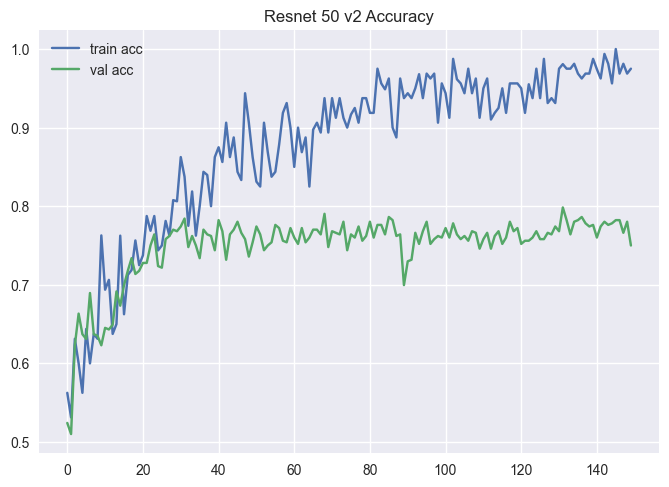

In [91]:
# accuracies
plt.plot(resnet_50_v2_history.history['acc'], label='train acc')
plt.plot(resnet_50_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 50 v2 Accuracy")
plt.legend()
plt.show()

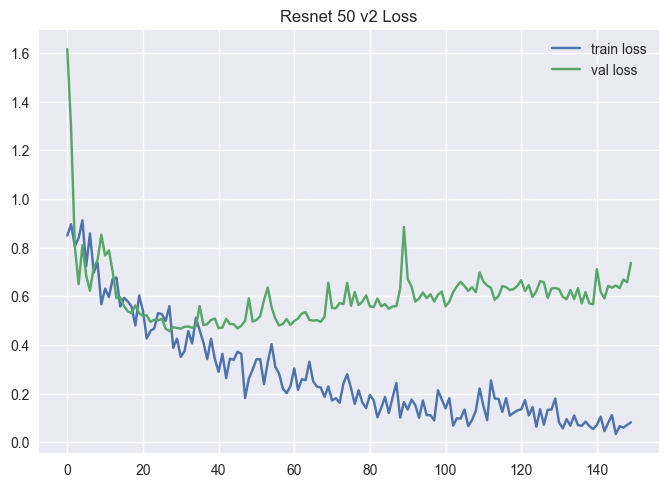

In [92]:
# loss
plt.plot(resnet_50_v2_history.history['loss'], label='train loss')
plt.plot(resnet_50_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 v2 Loss")
plt.legend()
plt.show()

In [93]:
#predict
y_pred=resnet_50_v2_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

16/16 [==============================] - 1s 53ms/step
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       215
           1       0.78      0.69      0.73       285

    accuracy                           0.71       500
   macro avg       0.71      0.72      0.71       500
weighted avg       0.72      0.71      0.72       500



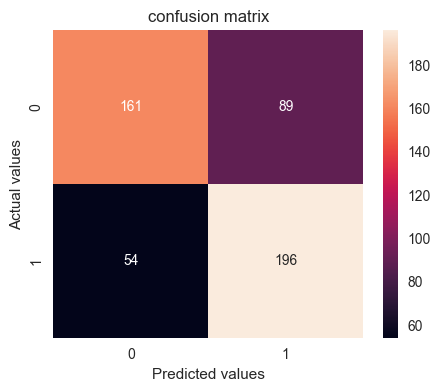

In [94]:
plt.figure(figsize=(5,4))
plt.title("confusion matrix")
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

[[161  54]
 [ 89 196]]
16/16 [==============================] - 2s 109ms/step


C:\Users\91997\AppData\Local\Temp\ipykernel_19360\1837746427.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


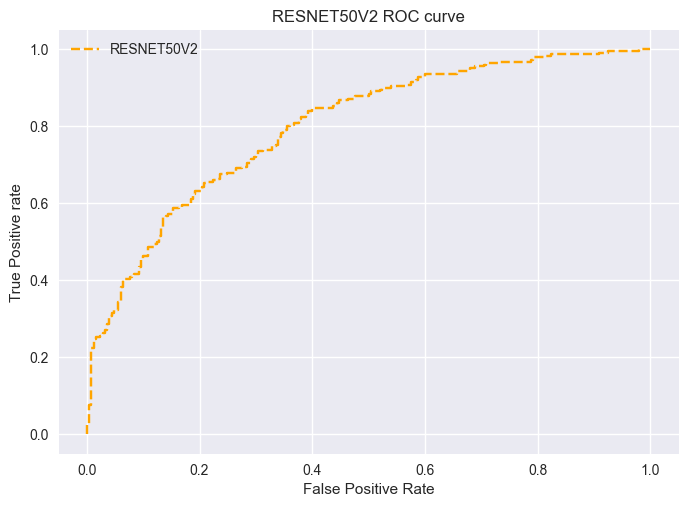

In [95]:
print(confusion_matrix(y_pred,y_test))
pred_prob3 =vgg_model.predict(x_test)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)

plt.style.use('seaborn')

plt.plot(fpr3, tpr3, linestyle='--',color='orange', label=r'RESNET50V2')
plt.title('RESNET50V2 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [96]:
resnet_50_v2_model.save("Model\AutismDetection_resnet_50_v2_model.h5", save_format="h5")

del resnet_50_v2_history
del y_pred

gc.collect()

29739

# RESNET101V2

In [97]:
resnet_101_v2 = ResNet101V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [98]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_101_v2.layers:
    layer.trainable = False

In [99]:
x = Flatten()(resnet_101_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_101_v2_model = Model(inputs=resnet_101_v2.input, outputs=prediction)
# view the structure of the model
resnet_101_v2_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [100]:
resnet_101_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="SGD", metrics=['acc'])

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

# fit the model
resnet_101_v2_history = resnet_101_v2_model.fit(x_train, y_train, validation_data=(x_val,y_val), steps_per_epoch = 10, epochs=150, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_val.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/150
10/10 [==============================] - 8s 412ms/step - loss: 1.1201 - acc: 0.4750 - val_loss: 2.2115 - val_acc: 0.5202
Epoch 2/150
10/10 [==============================] - 2s 251ms/step - loss: 0.9592 - acc: 0.5312 - val_loss: 1.3135 - val_acc: 0.5484
Epoch 3/150
10/10 [==============================] - 2s 251ms/step - loss: 0.7573 - acc: 0.6187 - val_loss: 0.9682 - val_acc: 0.5847
Epoch 4/150
10/10 [==============================] - 2s 250ms/step - loss: 0.8631 - acc: 0.6250 - val_loss: 0.6986 - val_acc: 0.6250
Epoch 5/150
10/10 [==============================] - 2s 251ms/step - loss: 0.7550 - acc: 0.6250 - val_loss: 0.7486 - val_acc: 0.6089
Epoch 6/150
10/10 [==============================] - 2s 253ms/step - loss: 0.6432 - acc: 0.7000 - val_loss: 0.7182 - val_acc: 0.6190
Epoch 7/150
10/10 [==============================] - 2s 250ms/step - loss: 0.6995 - acc: 0.6562 - val_loss: 0.7000 - val_acc: 0.6310
Epoch 8/150
10/10 [==============================] - 2s 253ms/step - 

In [101]:
resnet_101_v2_loss,resnet_101_v2_acc = resnet_101_v2_model.evaluate(x_test,y_test,batch_size=32)
print("resnet_101_v2 Loss:", resnet_101_v2_loss)
print("resnet_101_v2 Accuracy:", resnet_101_v2_acc*100, "%")

16/16 [==============================] - 1s 90ms/step - loss: 0.8899 - acc: 0.7240
resnet_101_v2 Loss: 0.8898614048957825
resnet_101_v2 Accuracy: 72.39999771118164 %


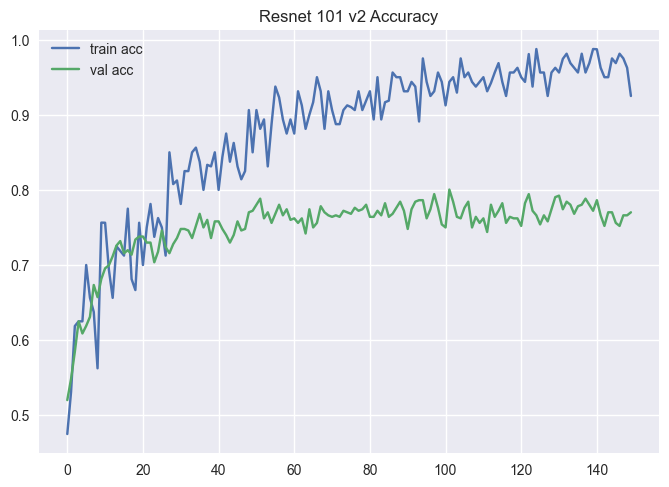

In [102]:
# accuracies
plt.plot(resnet_101_v2_history.history['acc'], label='train acc')
plt.plot(resnet_101_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 101 v2 Accuracy")
plt.legend()
plt.show()

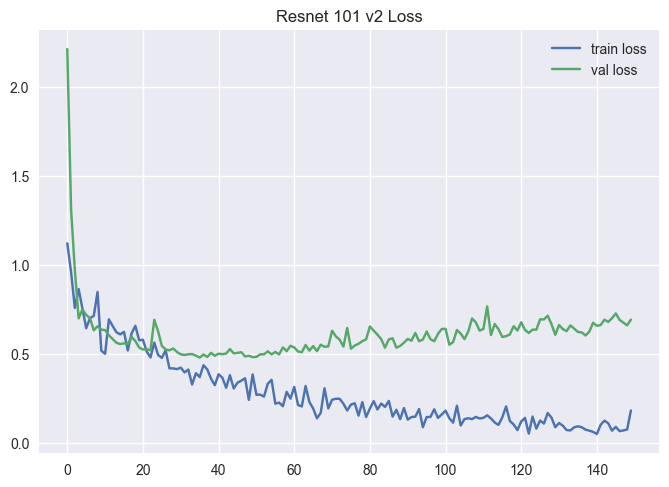

In [103]:
# loss
plt.plot(resnet_101_v2_history.history['loss'], label='train loss')
plt.plot(resnet_101_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 101 v2 Loss")
plt.legend()
plt.show()

In [104]:
#predict
y_pred=resnet_101_v2_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

16/16 [==============================] - 3s 91ms/step
              precision    recall  f1-score   support

           0       0.66      0.75      0.71       220
           1       0.78      0.70      0.74       280

    accuracy                           0.72       500
   macro avg       0.72      0.73      0.72       500
weighted avg       0.73      0.72      0.72       500



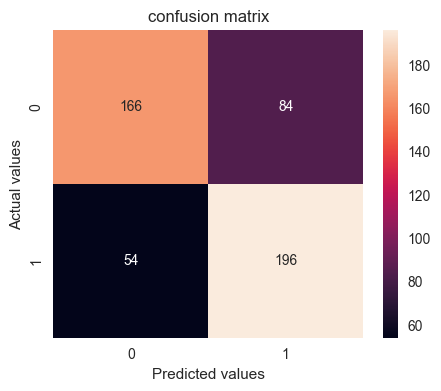

In [105]:
plt.figure(figsize=(5,4))
plt.title("confusion matrix")
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

[[166  54]
 [ 84 196]]
16/16 [==============================] - 2s 109ms/step


C:\Users\91997\AppData\Local\Temp\ipykernel_19360\4160645141.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


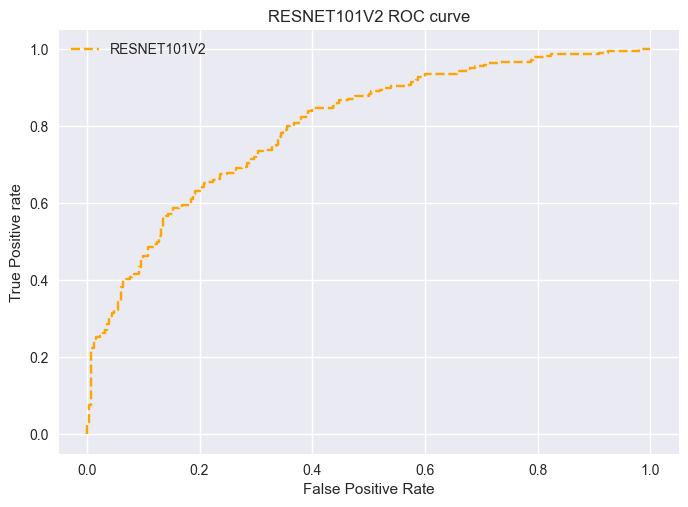

In [106]:
print(confusion_matrix(y_pred,y_test))
pred_prob4 =vgg_model.predict(x_test)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)

plt.style.use('seaborn')

plt.plot(fpr4, tpr4, linestyle='--',color='orange', label=r'RESNET101V2')
plt.title('RESNET101V2 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [107]:
resnet_101_v2_model.save("Model\AutismDetection_resnet_101_v2_model.h5", save_format="h5")

del resnet_101_v2_history
del y_pred

gc.collect()

46055

# Model comparision

[70.99999785423279, 52.20000147819519, 71.39999866485596, 72.39999771118164]


Text(0.5, 1.0, 'Accuracy score Comparison (Higher is better)')

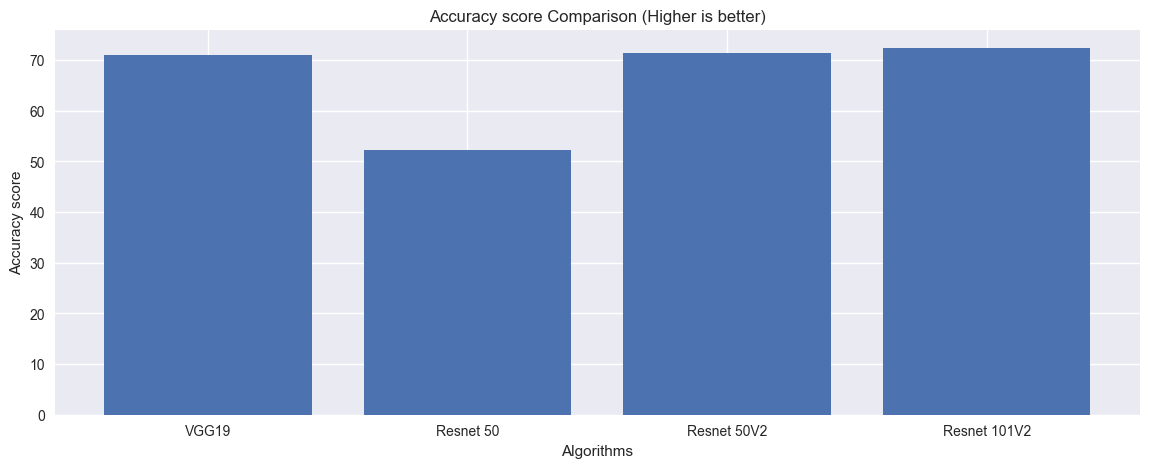

In [108]:
algorithms = ["VGG19","Resnet 50","Resnet 50V2","Resnet 101V2"]
Accuracy = [vgg_acc*100,resnet_50_acc*100,resnet_50_v2_acc*100,resnet_101_v2_acc*100]
print(Accuracy)

plt.figure(figsize=[14,5])
plt.bar(algorithms, Accuracy)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")
plt.title("Accuracy score Comparison (Higher is better)")